# Introduction


Based on the paper: Dynamic Routing Between Capsules, by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017).

Inspired in part from Aurélien Géron (https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb)


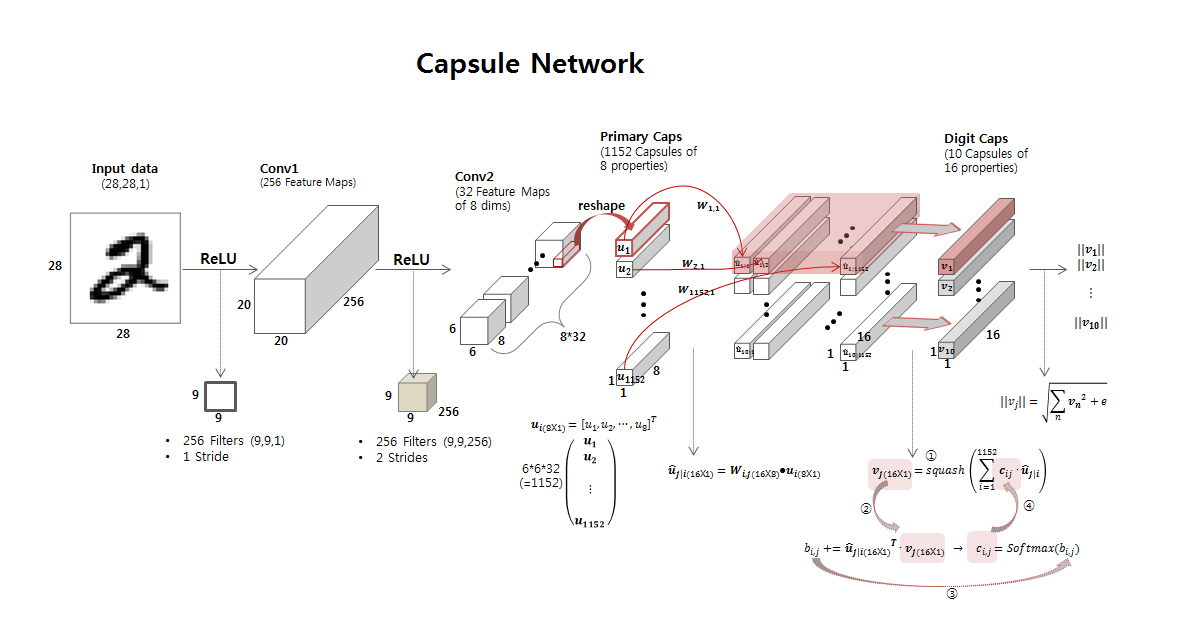

In [1]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/CapsuleNet2.png', width="100%")

# Imports

In [2]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load MNIST DATA

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Input Images

Shape the input data to 28x28 matrix and grayscale

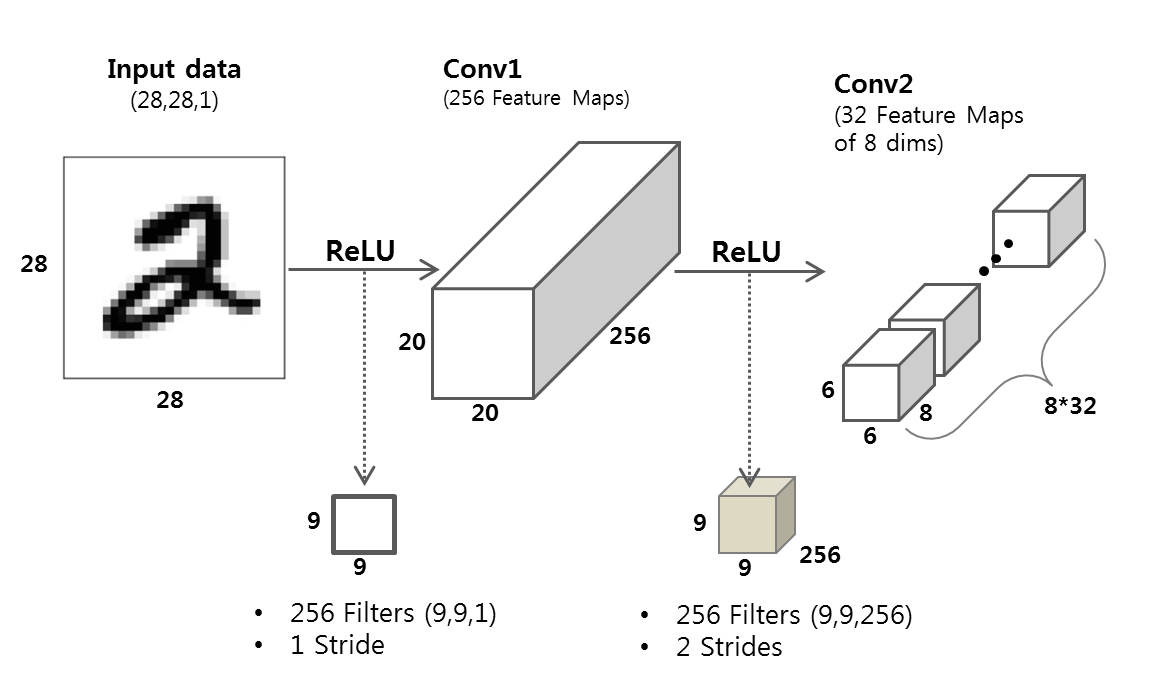

In [4]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/first_Step.png', width="100%")

In [5]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

# Set the parameters of Convolutional layers

(1) 1st Convolutional layer
  - 256 of Filters (9x9x1)
  - Activation : ReLU
  - 1 stride
  
(2) 2nd Convolutional layer 
  - 256(=32*8) of Filters (9x9x256)
  - Activation : ReLU
  - 2 strides
 
 => This layer will be a Primay Capsule Layer which contains 1152 capsules with 8 properties
    (6x6x8, 32) => (6x6x32, 8)

In [6]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [7]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

# Reshape Conv2 layer's Output

Next, we reshape the output of the 2nd Convolutional layer to construct many capsules and properties.           
We can save more detailed information dervied from each properties by constructing capsules 

Then, the output of `conv2` is an array containing 256(=8*32) feature maps, where each feature map is 6×6.

From this, we could reshape to 1152 capsules composing 8 dimensions(1x8) of each.

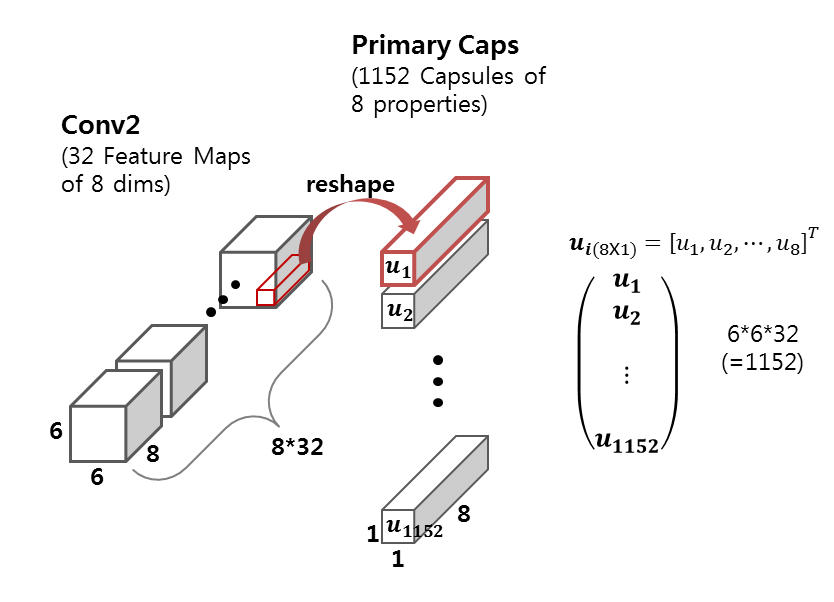

In [8]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/second_step.png', width="100%")

In [9]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

# Constructing the shape of predicted output
## (1) Change dimension

Let's say we will construct the Digit Caps. Layer containing 10 capsules(Target label has 10 classes) with 16 properties each.  
Then we need to transform $\, \mathbf{u}_i$ (8x1) matrix to (16x1).

The reason of transformation is to compute the predicted output of each digits(1~10)  
Setting 10 predicted vectors as below,  
$\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$

We can transform an 8D vector into a 16D vector.

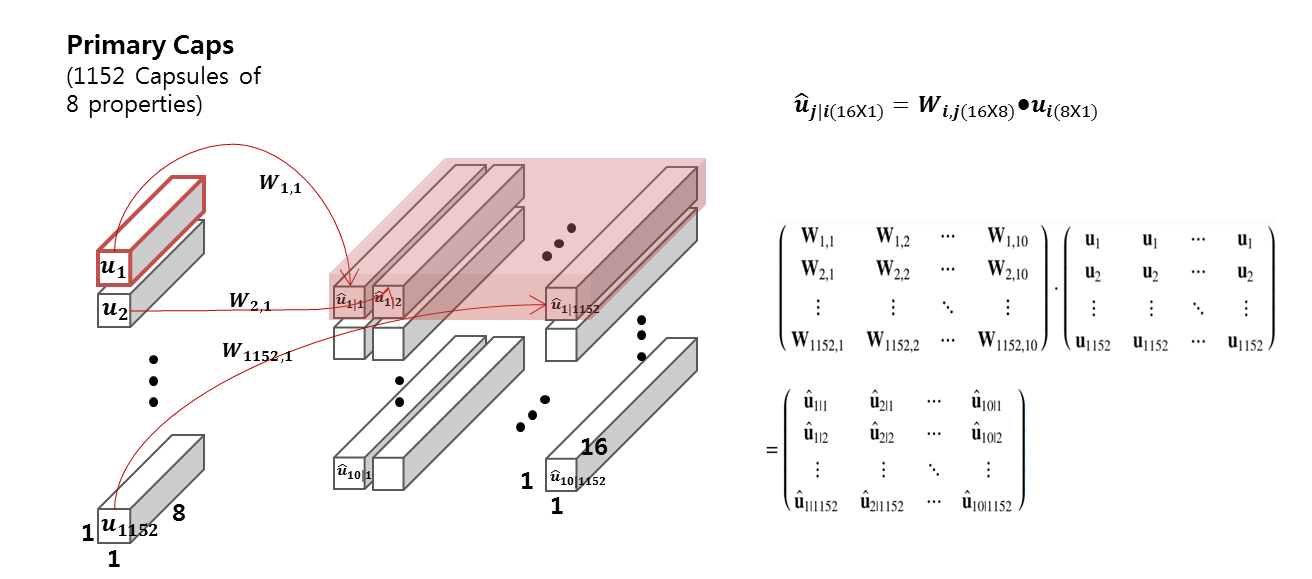

In [10]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/third_step.png', width="100%")

In [11]:
caps2_n_caps = 10
caps2_n_dims = 16

In [12]:
init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [13]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

## (2) Reduce the predictive output value between 0 to 1

After generating $\hat{\mathbf{u}}_{j|i}$ values, we compute the routing weights($\mathbf{c}_i$) and multiple with each $\hat{\mathbf{u}}_{j|i}$.  
$\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$

$\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$, $\mathbf{b}_{1}$ <- 0

And then, use squash function as below to make the output vectors be probability.    
$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

Finally, we apply the norm function to each output vector to obtain the probability value of each digits.

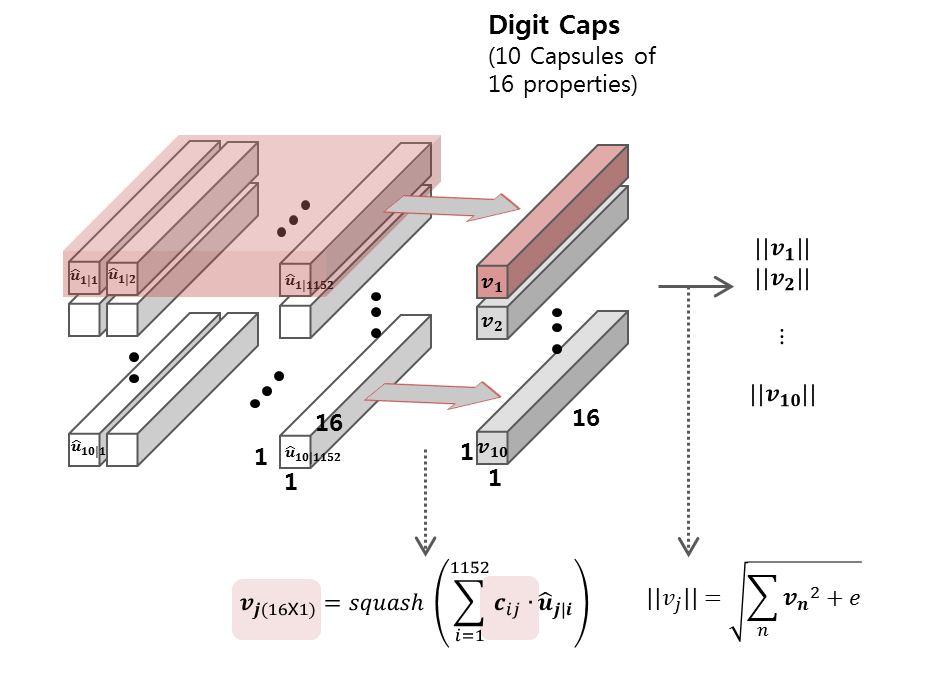

In [14]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/firth_step.png', width="100%")

In [15]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [16]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [17]:
#caps1_output: (?, 1152,8) => (?, 1152,8,1) => (?,1152,1,8,1) => (?, 1152,10,8,1) 
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded") 
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

# Routing by agreement

(1) Initialize the raw routing weights $b_{i,j}$ to zero -> $c_{i,j}$ to 0.5   
(2) $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$    
(3) $\mathbf{v}_j = \operatorname{squash}(\mathbf{s_{j}})$   
(4) Update $b_{i,j}$ as,   
    $b_{i,j}$ += $\mathbf{v}_j * \hat{\mathbf{u}}_{j|i}$
    
 **If predicted output vector(v) and previous vector(u) directs same way and looks similar, then c grows up**


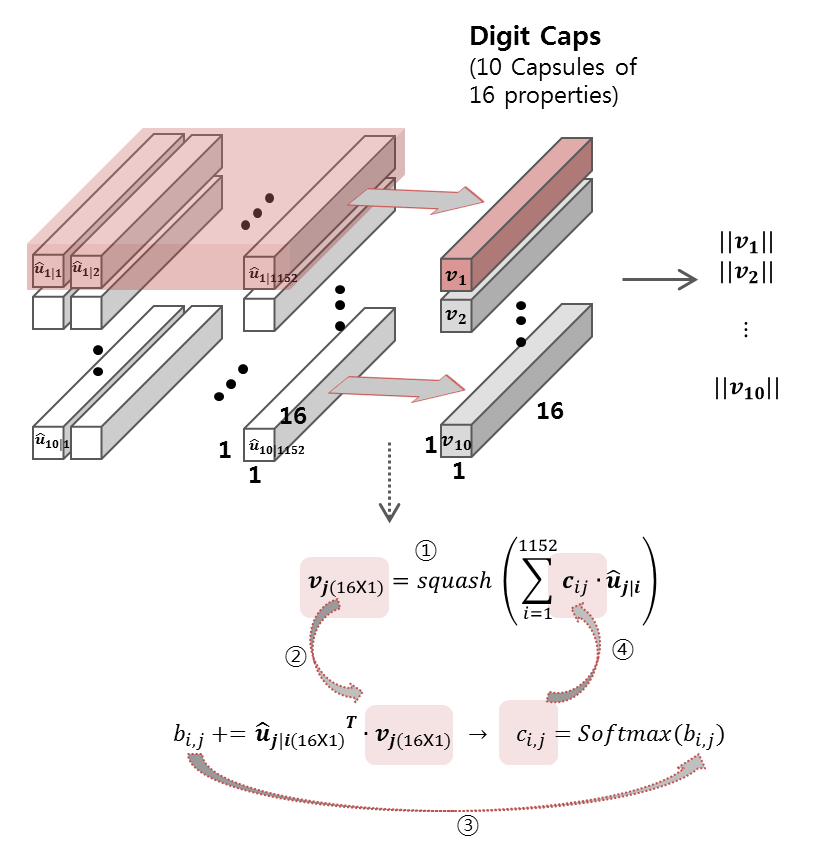

In [18]:
from IPython.display import Image
Image(filename='C:/Users/user/Desktop/논문/fifth_step.png', width="100%")

In [19]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

In [20]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

In [21]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [22]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

### Round 2

In [23]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [24]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [25]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [26]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [27]:
caps2_output = caps2_output_round_2

In [28]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [29]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba") #[0,0,0,0,.7,0,.2,.1,0,0]

In [30]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [31]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")